# John Park

## Setting up the word vectors and the clusters

In [2]:
import os
import codecs
from docx import *
import docx2txt


data_dir = os.path.join('Resumes')
resume_count = 0
resume_text = "all_text1.txt"

with codecs.open(resume_text,'w',encoding='utf_8') as resume_txt:
    for filename in os.listdir(data_dir):
        s = ""
        if filename.endswith(".docx"):
            location = str(os.path.join(data_dir,filename))
            #document = Document(location)
            #for paragraph in document.paragraphs:
            #    s += str(paragraph.text.encode(errors='ignore'))
            s = docx2txt.process(location)
            resume_txt.write(s+'\\n'+'\n')
            resume_count += 1
            
print(resume_count)

9


In [3]:
import spacy
import pandas as pd
import itertools as it

nlp = spacy.load('en')

RuntimeError: Model 'en' not installed. Please run 'python -m spacy.en.download' to install latest compatible model.

In [ ]:
with codecs.open(resume_text,encoding="utf_8") as f:
    sample_res = list(it.islice(f,8,9))[0]
    sample_res = sample_res.replace('\\n','\n')
print(sample_res)  

In [37]:
parsed_res_sample = nlp(sample_res)
print(parsed_res_sample)

Core Competencies:



In [38]:
for num,entity in enumerate(parsed_res_sample):
    print("Entity",entity, '-',entity.ent_type_)

Entity Core - 
Entity Competencies - 
Entity : - 
Entity 
 - 


In [39]:
token_text = [token.orth_ for token in parsed_res_sample]
token_lemma = [token.lemma_ for token in parsed_res_sample]
token_shape = [token.shape_ for token in parsed_res_sample]
d = list(zip(token_text,token_lemma,token_shape))
pd.DataFrame(data =d,\
            columns=['token_text','token_lemma','token_shape'])


,token_text,token_lemma,token_shape
0,Core,core,Xxxx
1,Competencies,competency,Xxxxx
2,:,:,:
3,\n,\n,\n


In [40]:
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence

def punct_space(token):
    "helper that elimates puncations and whitespace"
    return token.is_punct or token.is_space

def line_review(filename):
    "read reviews from the file and un-escapes orignal line break"
    with codecs.open(filename,encoding='utf_8') as f:
        for res in f:
            yield res.replace('\\n','\n')
 
def lemmatized_sentence_corpus(filename):
    "use spacy to parse, lemmatize and yield sentences"
    for parsed_res in nlp.pipe(line_review(filename),batch_size=10000,n_threads=3):
        for sent in parsed_res.sents:
            yield u' '.join([token.lemma_ for token in sent if not punct_space(token)])
            


In [41]:
unigram_filepath = 'unigram_sentences.txt'

In [42]:
with codecs.open(unigram_filepath,'w',encoding='utf_8') as f:
    for sent in lemmatized_sentence_corpus(resume_text):
        f.write(sent+'\n')

In [43]:
normal_res = LineSentence(unigram_filepath)

In [44]:
from gensim.models import Word2Vec
word2vec_file = "vector_models"

In [45]:
res2vec = Word2Vec(normal_res,size=200,window=5,sg=1,workers=4)
res2vec.save(word2vec_file)

for i in range(1,15):
    res2vec.train(normal_res,total_examples=res2vec.corpus_count, epochs=res2vec.iter)
    res2vec.save(word2vec_file)
    
res2vec = Word2Vec.load(word2vec_file)
res2vec.init_sims()

In [46]:
ordered = [(term,voc.index,voc.count)for term, voc in res2vec.wv.vocab.items()]
ordered_terms,term_indices,term_count = zip(*ordered)
word_vectors = pd.DataFrame(res2vec.wv.syn0[term_indices,:],index=ordered_terms)

word_vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
core,0.122443,-0.252213,-0.428362,-0.513357,-0.577219,-0.318699,0.699252,0.237295,-0.447458,0.390168,...,-0.344949,0.290918,0.003984,0.099427,-0.190856,0.073107,0.070277,-0.092188,0.043209,0.313530
competency,0.142567,-0.601963,-0.092267,-0.295767,-0.105996,0.109508,0.263730,0.037018,0.277004,0.332109,...,-0.287402,0.029289,0.444887,-0.069543,0.242374,-0.284550,-0.156958,0.141327,-0.173233,0.475339
human,-0.154698,-0.657310,-0.122818,-0.181482,-0.689875,0.231959,0.860371,0.189320,0.429886,-0.155384,...,-0.739953,0.343228,-0.025057,0.286132,-0.462639,0.437712,0.022524,-0.244359,-0.454868,-0.029318
resource,-0.237674,-0.207000,-0.055034,0.456402,-0.859434,0.197648,0.071974,0.405868,-0.054253,-0.326990,...,-0.566640,0.077566,0.541023,0.089828,0.021521,0.121939,-0.076982,0.303278,-0.361079,0.410418
management,-0.051744,-0.289030,0.166857,-0.451824,0.138203,-0.003642,-0.212571,0.366649,0.425891,-0.051442,...,-0.248683,0.414089,0.067285,0.281904,-0.216630,0.201774,-0.358986,0.369576,-0.326497,-0.044211


In [47]:
res2vec.n_similarity(['python'],['java'])

0.37076537254826891

In [48]:
def get_related_terms(token,topn=10):
    "get the top n most similar terms"
    for word,similar in res2vec.wv.most_similar(positive = [token],topn=topn):
        print(word,':',round(similar,3))

In [49]:
get_related_terms('python')

wlst : 0.57
ocaml : 0.55
languages : 0.475
dhtml : 0.464
css : 0.46
json : 0.458
pages : 0.452
jython : 0.45
html5 : 0.45
predictive : 0.448


In [50]:
get_related_terms('analyst')

sr : 0.46
junior : 0.431
08 : 0.368
programmer : 0.345
developers : 0.344
ltd. : 0.344
attended : 0.34
ba : 0.334
coordinator : 0.333
ltd : 0.33


In [51]:
from sklearn.manifold import TSNE
import _pickle as pickle

tsne_input = word_vectors.drop(spacy.en.English.Defaults.stop_words,errors='ignore')
tsne_input.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
core,0.122443,-0.252213,-0.428362,-0.513357,-0.577219,-0.318699,0.699252,0.237295,-0.447458,0.390168,...,-0.344949,0.290918,0.003984,0.099427,-0.190856,0.073107,0.070277,-0.092188,0.043209,0.313530
competency,0.142567,-0.601963,-0.092267,-0.295767,-0.105996,0.109508,0.263730,0.037018,0.277004,0.332109,...,-0.287402,0.029289,0.444887,-0.069543,0.242374,-0.284550,-0.156958,0.141327,-0.173233,0.475339
human,-0.154698,-0.657310,-0.122818,-0.181482,-0.689875,0.231959,0.860371,0.189320,0.429886,-0.155384,...,-0.739953,0.343228,-0.025057,0.286132,-0.462639,0.437712,0.022524,-0.244359,-0.454868,-0.029318
resource,-0.237674,-0.207000,-0.055034,0.456402,-0.859434,0.197648,0.071974,0.405868,-0.054253,-0.326990,...,-0.566640,0.077566,0.541023,0.089828,0.021521,0.121939,-0.076982,0.303278,-0.361079,0.410418
management,-0.051744,-0.289030,0.166857,-0.451824,0.138203,-0.003642,-0.212571,0.366649,0.425891,-0.051442,...,-0.248683,0.414089,0.067285,0.281904,-0.216630,0.201774,-0.358986,0.369576,-0.326497,-0.044211


In [52]:
tsne_file = 'tsne_models'
tsne_vectors_file = 'tsne_vectors.npy'

In [53]:
tsne = TSNE()
tnse_vectors = tsne.fit_transform(tsne_input.values)
with open(tsne_file, 'wb') as f:
    pickle.dump(tsne,f)
    
pd.np.save(tsne_vectors_file,tnse_vectors)

with open(tsne_file,'rb') as f:
    tnse = pickle.load(f)
tnse_vectors = pd.np.load(tsne_vectors_file)

tnse_vectors = pd.DataFrame(tnse_vectors,index = pd.Index(tsne_input.index),columns=['x','y'])

In [54]:
tnse_vectors['word'] = tnse_vectors.index
tnse_vectors.head()

,x,y,word
core,9.663403,2.292927,core
competency,4.410144,-3.900633,competency
human,-8.822267,-13.799307,human
resource,0.696946,10.953637,resource
management,-1.091064,2.550218,management


In [55]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value

output_notebook()

Loading BokehJS ...

In [56]:
plot_data = ColumnDataSource(tnse_vectors)
# create the plot and configure the
# title, dimensions, and tools
tsne_plot = figure(title=u't-SNE Word Embeddings',
                   plot_width = 800,
                   plot_height = 800,
                   tools= (u'pan, wheel_zoom, box_zoom,'
                           u'box_select, resize, reset'),
                   active_scroll=u'wheel_zoom')

# add a hover tool to display words on roll-over
tsne_plot.add_tools( HoverTool(tooltips = u'@word') )

# draw the words as circles on the plot
tsne_plot.circle(u'x', u'y', source=plot_data,
                 color=u'blue', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')

# configure visual elements of the plot
tsne_plot.title.text_font_size = value(u'16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None

# engage!
show(tsne_plot);

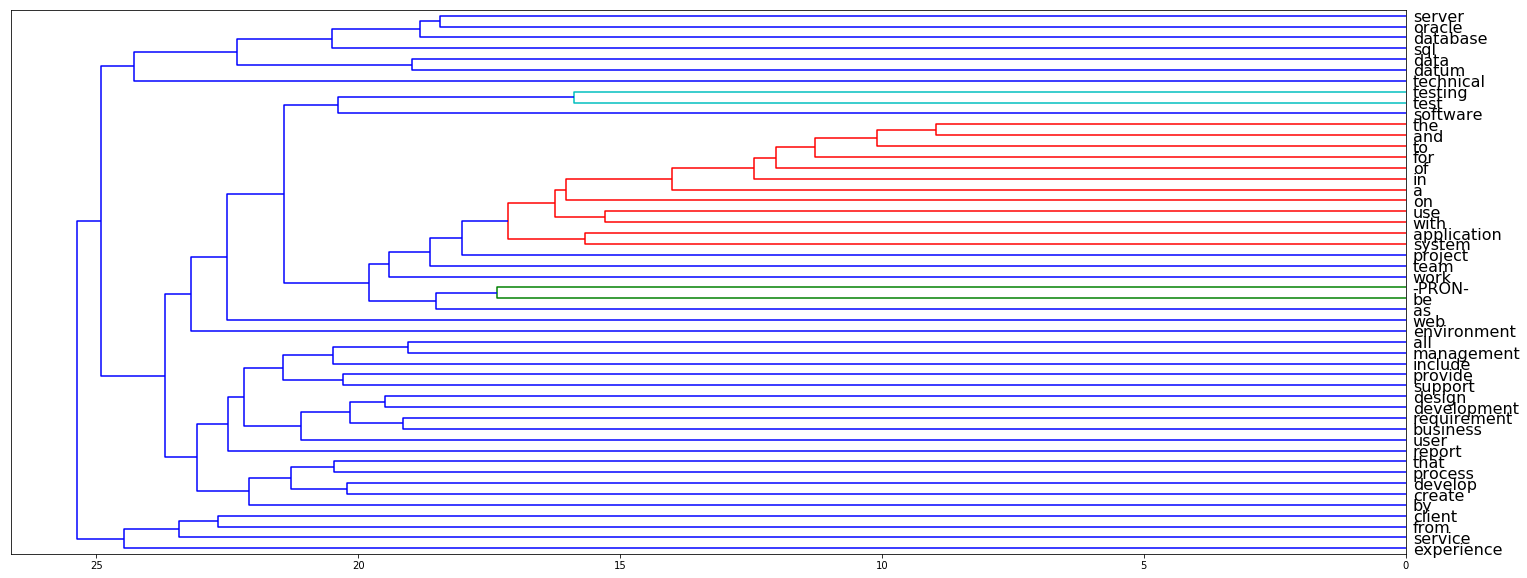

In [57]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

l=linkage(res2vec.wv.syn0[0:50],method='complete',metric='seuclidean')

plt.figure(figsize=(25,10))
dendrogram(
l,leaf_rotation=0,leaf_font_size=16,orientation='left',leaf_label_func=lambda v:str(res2vec.wv.index2word[v]))
plt.show()

In [58]:
from sklearn.cluster import KMeans


# Set "k" (num_clusters) to be 1/5th of the vocabulary size, or an
# average of 5 words per cluster
word_vectors = res2vec.wv.syn0
print(int(word_vectors.shape[0]/100))
num_clusters = int(word_vectors.shape[0]/100)

# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans( n_clusters = num_clusters )
idx = kmeans_clustering.fit_predict( word_vectors )

27


In [64]:
word_centroid_map = dict(zip( res2vec.wv.index2word, idx ))
for cluster in range(0,27):
    #
    # Print the cluster number  
    print ("\nCluster:",cluster)
    #
    # Find all of the words for that cluster number, and print them out
    words = []
    for key,item in word_centroid_map.items():
        if( item == cluster ):
            words.append(key)
    print(words)


Cluster: 0
['issue', 'change', 'defect', 'track', 'result', 'or', 'identify', 'problem', 'request', 'resolve', 'fix', 'resolution', 'any', 'bug', 'necessary', 'troubleshoot', 'recommend', 'find', 'not', 'address', 'when', 'timely', 'desk', 'equipment', 'before', 'and/or', 'trouble', 'cause', 'directly', 'ticket', 'remedy', 'finding', 'incident', 'respond', 'root', 'approve', 'bottleneck', 'close', 'manner', 'sla', 'measure', 'upper', 'potential', 'priority', 'possible', 'closure', 'correct', 'expectation', 'shoot', 'spr', 'skilled', 'concern', 'remediate', 'exceed', 'discover', 'proactively', 'question', 'arise', 'proactive', 'investigate', 'cc', 'deficiency', 'scr', 'discrepancy', 'diagnose', 'until', 'requests', 'fee', 'accordingly', 'triage', 'whenever']

Cluster: 1
['rule', 'transaction', 'electronic', 'hipaa', 'format', 'claim', 'healthcare', 'guideline', 'edi', '834', 'claims', 'regulation', '835', 'x12', '837', 'd', 'tpocs', 'icd', '270/271', '276/277', 'eligibility', '4010', '

Cluster: 22
['oracle', 'g', '11', 'soa', 'portal', '10', 'suite', 'middleware', 'bpm', 'content', 'db', 'fusion', 'directory', 'single', 'bpel', 'adf', 'oam', 'oid', 'obiee', 'logic', 'ldap', 'oim', 'identity', 'adapter', 'apex', 'sign', 'grid', 'r2', 'oaam', 'ovd', 'sso', 'webcenter', 'vm', 'osb', 'oud', 'rac', 'spatial', 'idam', 'idm', 'console', 'ucm', 'esb', '11gr2', 'composite', 'msde', 'prod', 'gis', '12c', 'suit', 'bus', 'jdeveloper', 'viewer', 'adapters', '11g/', 'b2b', 'gate', 'mediator', 'metadata', '10g/11', 'ebs', 'connector', 'owsm', 'rcu', 'products', 'po', 'inbound', 'catalog', 'sandbox', 'url', '10gas', 'ear', 'tenant', '11.5.10', 'em', 'deploying', 'wls', 'orchestration', 'p6', 'integrations', 'mlds', 'oracle10', 'iam', 'federation', 'soa11']

Cluster: 23
['security', 'status', 'risk', 'operate', 'assessment', 'major', 'audit', 'package', 'authorization', 'assign', 'deliverable', 'clearance', 'vulnerability', 'monthly', 'action', 'continuous', 'scan', 'act', 'regular',

## Labeling all the clusters and training the Naive Bayes model

In [109]:
import numpy as np
from sklearn.naive_bayes import GaussianNB
all_classes = [0,1,2,3]
clf = GaussianNB()

ctemp = np.array([res2vec.wv['issue']])
#cluster 0 - skills
for key,item in word_centroid_map.items():
    if( item == 0 ):
        ctemp=np.vstack([ctemp,res2vec.wv[key]])
samp = np.full(len(ctemp),0)
clf.partial_fit(ctemp,samp,classes=all_classes)

#Cluster 1 - skills
ctemp = np.array([res2vec.wv['rule']])
for key,item in word_centroid_map.items():
    if( item == 1 ):
        ctemp=np.vstack([ctemp,res2vec.wv[key]])
samp = np.full(len(ctemp),0)
clf.partial_fit(ctemp,samp,classes=all_classes)

#Cluster 2 - skills
ctemp = np.array([res2vec.wv['excel']])
for key,item in word_centroid_map.items():
    if( item == 2 ):
        ctemp=np.vstack([ctemp,res2vec.wv[key]])
samp = np.full(len(ctemp),0)
clf.partial_fit(ctemp,samp,classes=all_classes)

#Cluster 3 - Experience
ctemp = np.array([res2vec.wv['lead']])
for key,item in word_centroid_map.items():
    if( item == 3 ):
        ctemp=np.vstack([ctemp,res2vec.wv[key]])
samp = np.full(len(ctemp),1)
clf.partial_fit(ctemp,samp,classes=all_classes)

#Cluster 4 - Misc
ctemp = np.array([res2vec.wv['peoplesoft']])
for key,item in word_centroid_map.items():
    if( item == 4 ):
        ctemp=np.vstack([ctemp,res2vec.wv[key]])
samp = np.full(len(ctemp),2)
clf.partial_fit(ctemp,samp,classes=all_classes)

#Cluster 5 - Experience
ctemp = np.array([res2vec.wv['skill']])
for key,item in word_centroid_map.items():
    if( item == 5 ):
        ctemp=np.vstack([ctemp,res2vec.wv[key]])
samp = np.full(len(ctemp),1)
clf.partial_fit(ctemp,samp,classes=all_classes)

#Cluster 6 - Skills
ctemp = np.array([res2vec.wv['server']])
for key,item in word_centroid_map.items():
    if( item == 6 ):
        ctemp=np.vstack([ctemp,res2vec.wv[key]])
samp = np.full(len(ctemp),0)
clf.partial_fit(ctemp,samp,classes=all_classes)

#Cluster 7 - Experience
ctemp = np.array([res2vec.wv['the']])
for key,item in word_centroid_map.items():
    if( item == 7 ):
        ctemp=np.vstack([ctemp,res2vec.wv[key]])
samp = np.full(len(ctemp),1)
clf.partial_fit(ctemp,samp,classes=all_classes)

#Cluster 8 - Experience
ctemp = np.array([res2vec.wv['and']])
for key,item in word_centroid_map.items():
    if( item == 8 ):
        ctemp=np.vstack([ctemp,res2vec.wv[key]])
samp = np.full(len(ctemp),1)
clf.partial_fit(ctemp,samp,classes=all_classes)

#Cluster 9 - Experience
ctemp = np.array([res2vec.wv['bi']])
for key,item in word_centroid_map.items():
    if( item == 9 ):
        ctemp=np.vstack([ctemp,res2vec.wv[key]])
samp = np.full(len(ctemp),1)
clf.partial_fit(ctemp,samp,classes=all_classes)

#Cluster 10 - Experience
ctemp = np.array([res2vec.wv['employee']])
for key,item in word_centroid_map.items():
    if( item == 10 ):
        ctemp=np.vstack([ctemp,res2vec.wv[key]])
samp = np.full(len(ctemp),1)
clf.partial_fit(ctemp,samp,classes=all_classes)

#Cluster 11 - Experience
ctemp = np.array([res2vec.wv['time']])
for key,item in word_centroid_map.items():
    if( item == 11 ):
        ctemp=np.vstack([ctemp,res2vec.wv[key]])
samp = np.full(len(ctemp),1)
clf.partial_fit(ctemp,samp,classes=all_classes)

#Cluster 12 - Experience
ctemp = np.array([res2vec.wv['professional']])
for key,item in word_centroid_map.items():
    if( item == 12 ):
        ctemp=np.vstack([ctemp,res2vec.wv[key]])
samp = np.full(len(ctemp),1)
clf.partial_fit(ctemp,samp,classes=all_classes)

#Cluster 13 - Experience
ctemp = np.array([res2vec.wv['at']])
for key,item in word_centroid_map.items():
    if( item == 13 ):
        ctemp=np.vstack([ctemp,res2vec.wv[key]])
samp = np.full(len(ctemp),1)
clf.partial_fit(ctemp,samp,classes=all_classes)

#Cluster 14 - Experience
ctemp = np.array([res2vec.wv['information']])
for key,item in word_centroid_map.items():
    if( item == 14 ):
        ctemp=np.vstack([ctemp,res2vec.wv[key]])
samp = np.full(len(ctemp),1)
clf.partial_fit(ctemp,samp,classes=all_classes)

#Cluster 15 - Education
ctemp = np.array([res2vec.wv['university']])
for key,item in word_centroid_map.items():
    if( item == 15 ):
        ctemp=np.vstack([ctemp,res2vec.wv[key]])
samp = np.full(len(ctemp),3)
clf.partial_fit(ctemp,samp,classes=all_classes)

#Cluster 16 - Misc
ctemp = np.array([res2vec.wv['present']])
for key,item in word_centroid_map.items():
    if( item == 16 ):
        ctemp=np.vstack([ctemp,res2vec.wv[key]])
samp = np.full(len(ctemp),2)
clf.partial_fit(ctemp,samp,classes=all_classes)

#Cluster 17 - Skills
ctemp = np.array([res2vec.wv['java']])
for key,item in word_centroid_map.items():
    if( item == 17 ):
        ctemp=np.vstack([ctemp,res2vec.wv[key]])
samp = np.full(len(ctemp),0)
clf.partial_fit(ctemp,samp,classes=all_classes)

#Cluster 18 - Skills
ctemp = np.array([res2vec.wv['java']])
for key,item in word_centroid_map.items():
    if( item == 18 ):
        ctemp=np.vstack([ctemp,res2vec.wv[key]])
samp = np.full(len(ctemp),0)
clf.partial_fit(ctemp,samp,classes=all_classes)

#Cluster 19 - Experience
ctemp = np.array([res2vec.wv['employee']])
for key,item in word_centroid_map.items():
    if( item == 19 ):
        ctemp=np.vstack([ctemp,res2vec.wv[key]])
samp = np.full(len(ctemp),1)
clf.partial_fit(ctemp,samp,classes=all_classes)

#Cluster 20 - Experience
ctemp = np.array([res2vec.wv['employee']])
for key,item in word_centroid_map.items():
    if( item == 20 ):
        ctemp=np.vstack([ctemp,res2vec.wv[key]])
samp = np.full(len(ctemp),1)
clf.partial_fit(ctemp,samp,classes=all_classes)

#Cluster 21 - Skills
ctemp = np.array([res2vec.wv['java']])
for key,item in word_centroid_map.items():
    if( item == 21 ):
        ctemp=np.vstack([ctemp,res2vec.wv[key]])
samp = np.full(len(ctemp),0)
clf.partial_fit(ctemp,samp,classes=all_classes)

#Cluster 22 - Skills
ctemp = np.array([res2vec.wv['java']])
for key,item in word_centroid_map.items():
    if( item == 22 ):
        ctemp=np.vstack([ctemp,res2vec.wv[key]])
samp = np.full(len(ctemp),0)
clf.partial_fit(ctemp,samp,classes=all_classes)

#Cluster 23 - Experience
ctemp = np.array([res2vec.wv['employee']])
for key,item in word_centroid_map.items():
    if( item == 23 ):
        ctemp=np.vstack([ctemp,res2vec.wv[key]])
samp = np.full(len(ctemp),1)
clf.partial_fit(ctemp,samp,classes=all_classes)

#Cluster 24 - Misc
ctemp = np.array([res2vec.wv['+']])
for key,item in word_centroid_map.items():
    if( item == 24 ):
        ctemp=np.vstack([ctemp,res2vec.wv[key]])
samp = np.full(len(ctemp),2)
clf.partial_fit(ctemp,samp,classes=all_classes)

#Cluster 25 - Skills
ctemp = np.array([res2vec.wv['java']])
for key,item in word_centroid_map.items():
    if( item == 25 ):
        ctemp=np.vstack([ctemp,res2vec.wv[key]])
samp = np.full(len(ctemp),0)
clf.partial_fit(ctemp,samp,classes=all_classes)

#Cluster 26 - Education
ctemp = np.array([res2vec.wv['human']])
for key,item in word_centroid_map.items():
    if( item == 26 ):
        ctemp=np.vstack([ctemp,res2vec.wv[key]])
samp = np.full(len(ctemp),3)
clf.partial_fit(ctemp,samp,classes=all_classes)

GaussianNB(priors=None)

## Determine category of input word

In [123]:
testWord = 'university'
totest = np.array(res2vec.wv[testWord])
totest = totest.reshape(1,-1)
prediction=clf.predict(totest)
print(prediction)
if prediction[0] == 0:
    print(testWord + " is in SKILLS")
if prediction[0] == 1:
    print(testWord + " is in EXPERIENCE")
if prediction[0] == 2:
    print(testWord + " is in MISC")
if prediction[0] == 3:
    print(testWord + " is in EDUCATION")

[3]
university is in EDUCATION


# Organization Extraction

In [3]:
import sys
import codecs
from docx import *
from io import StringIO

location = r'/Users/trere11/Desktop/Paradyme/RSR_Parsing/Resumes/AmandaYuResume.docx'
document = Document(location)
s = ""
for paragraph in document.paragraphs:
    s += str(paragraph.text.encode(errors='ignore'))

In [4]:
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize

st = StanfordNERTagger('/Users/trere11/Desktop/stanford-ner-2017-06-09/classifiers/english.all.3class.distsim.crf.ser.gz','/Users/trere11/Desktop/stanford-ner-2017-06-09/stanford-ner.jar',encoding='utf-8')
tokenized_text = word_tokenize(s)
classified_text = st.tag(tokenized_text)

print(classified_text)

[("b'EDUCATION'b'Bachelor", 'O'), ('of', 'O'), ('Mathematics\\t', 'O'), ('\\t', 'O'), ('\\t', 'O'), ('\\t', 'O'), ('University', 'ORGANIZATION'), ('of', 'ORGANIZATION'), ('Maryland', 'ORGANIZATION'), (',', 'ORGANIZATION'), ('College', 'ORGANIZATION'), ('Park', 'ORGANIZATION'), ("'b", 'ORGANIZATION'), ("'", 'ORGANIZATION'), ('&', 'ORGANIZATION'), ('Computer', 'ORGANIZATION'), ('Science', 'ORGANIZATION'), ('Minor\\t', 'ORGANIZATION'), ('\\t\\t\\t', 'ORGANIZATION'), ('School', 'ORGANIZATION'), ('of', 'ORGANIZATION'), ('Computer', 'ORGANIZATION'), (',', 'O'), ('Mathematical', 'ORGANIZATION'), ('&', 'ORGANIZATION'), ('Natural', 'ORGANIZATION'), ('Sciences', 'ORGANIZATION'), ("'b'Excepted", 'O'), ('Grad', 'O'), (':', 'O'), ('Summer', 'O'), ('2017\\t\\t\\t\\t\\t\\t\\t', 'O'), ('\\t', 'O'), ("'b", 'O'), ("''", 'O'), ("b'COMPUTER", 'O'), ("SKLLS'b'Programming", 'O'), ('Language', 'O'), (':', 'O'), ('C', 'O'), (',', 'O'), ('Java', 'O'), (',', 'O'), ('C++', 'O'), (',', 'O'), ('HTML', 'O'), (',', 

In [7]:
for x in classified_text:
    if x[1] == 'ORGANIZATION':
        print(x[0])

University
of
Maryland
,
College
Park
'b
'
&
Computer
Science
Minor\t
\t\t\t
School
of
Computer
Mathematical
&
Natural
Sciences
MATLAB
Assembly
EchoStar
CISCO
EchoStar
HMAC
AES
